# AI Stock Predictor

## Roadmap
1. Download and filter historic data of a stock (or multiple stocks)
2. Normalize stock values for our AI model
3. Split up dataset of stock values into training and testing datasets
4. Set up AI model
5. Train and test AI model
6. Fetch and filter latest history of stock
7. Predict recent Close value with AI and compare it to the real Close value
8. Improve our AI model with experimentation

Install **YFinance**, **pandas**, and **pytorch** (for local users, not Colab)

`pip install -U yfinance pandas --no-cache-dir`

`pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124`

In [1]:
import yfinance as yf
import pandas as pd
import torch

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

We want to make an AI model that can predict future Market Close values based on the stock's past values. We can retrieve a stock's history from a certain timeframe (3 months ago).

Add a ticker tracking a stock
 
*Ticker = set of letters (e.g., MSFT for microsoft) identifying a stock, providing relevant stock history like market value

We will use NVIDIA (NVDA), a semiconductor company known for making GPUs, for this example

In [3]:
nvda = yf.Ticker("NVDA") 

In [4]:
raw_df = nvda.history(period="3mo").astype(float) # ensure consistency

In [5]:
raw_df.isnull().values.any() # no null values, so we dont have to worry about removing them

False

In [6]:
raw_df.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-05-03 00:00:00-04:00,87.781790,89.273664,87.032851,88.781708,398341000.0,0.0,0.0
2024-05-06 00:00:00-04:00,89.382657,92.212426,89.047685,92.132431,376203000.0,0.0,0.0
2024-05-07 00:00:00-04:00,91.090516,91.773459,89.003690,90.546562,437342000.0,0.0,0.0
2024-05-08 00:00:00-04:00,89.475655,91.186513,89.412656,90.404579,325721000.0,0.0,0.0
2024-05-09 00:00:00-04:00,90.521567,91.064522,88.223759,88.739716,378013000.0,0.0,0.0


We want our AI model to predict what the Close values will be. To do this, we must categorize this historic data into two sections: training and testing data.


Training Data (**Features**): Open, High, Low, Volume (They seem to have significant value)

Testing Data (**Labels**): Close 

In [7]:
raw_df.drop(columns=["Dividends", "Stock Splits"], inplace=True)  # inplace since we aren't assigning to new variable

In [8]:
features_df = raw_df.drop("Close", axis=1) # features is everything except Close column, notice how we use axis=1 to select column since it will try to look in rows
label_df = raw_df.pop("Close") # this will be its own column
label_df.rename("Close", inplace=True)

Date
2024-05-03 00:00:00-04:00     88.781708
2024-05-06 00:00:00-04:00     92.132431
2024-05-07 00:00:00-04:00     90.546562
2024-05-08 00:00:00-04:00     90.404579
2024-05-09 00:00:00-04:00     88.739716
                                ...    
2024-07-29 00:00:00-04:00    111.589996
2024-07-30 00:00:00-04:00    103.730003
2024-07-31 00:00:00-04:00    117.019997
2024-08-01 00:00:00-04:00    109.209999
2024-08-02 00:00:00-04:00    107.269997
Name: Close, Length: 63, dtype: float64

In [9]:
features_df.shape, label_df.shape

((63, 4), (63,))

To make sure our AI model does not worry too much on the numbers in our dataset, we will **normalize** our (training) data to ensure it only focuses on the patterns. We will use a MinMaxScaler from Scikit-Learn which scales all numbers respective to the lowest and highest number in the dataset.

Note that we do not standardize for our case, as we will use a loss function called Mean Square Error which will change our error scale to the value of the NVIDIA stock, rendering us unable to measure the accuracy and loss of our model.

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
feature_normalizer = MinMaxScaler(feature_range=(0, 1))
norm_df = feature_normalizer.fit_transform(features_df, y=label_df) # apply normalization to make a numpy array
features_df = pd.DataFrame(norm_df, index=features_df.index, columns=features_df.columns) # convert the normalized array to a dataframe once again

label_normalizer = MinMaxScaler()
norm_df = label_normalizer.fit_transform(label_df.to_frame()) # MinMaxScaler requires this
label_df = pd.DataFrame(norm_df, index=label_df.index, columns=["Close"]) # extra touch to rename it Close

In [12]:
features_df.head(5)

,Open,High,Low,Volume
Date,,,,
2024-05-03 00:00:00-04:00,0.000000,0.000000,0.000000,0.339452
2024-05-06 00:00:00-04:00,0.030775,0.057078,0.044392,0.305968
2024-05-07 00:00:00-04:00,0.063607,0.048553,0.043423,0.398441
2024-05-08 00:00:00-04:00,0.032563,0.037153,0.052433,0.229614
2024-05-09 00:00:00-04:00,0.052670,0.034783,0.026239,0.308706


In [13]:
label_df.head(5)

,Close
Date,
2024-05-03 00:00:00-04:00,0.000896
2024-05-06 00:00:00-04:00,0.072432
2024-05-07 00:00:00-04:00,0.038575
2024-05-08 00:00:00-04:00,0.035543
2024-05-09 00:00:00-04:00,0.000000


In [14]:
features_df.shape, label_df.shape

((63, 4), (63, 1))

We will separate our features and labels into training and testing data with the help of Scikit-Learn's TimeSeriesSplit function.

Unlike Scikit-Learn's train_test_split function, TimeSeriesSplit works like folding a paper with small folds, keeping time-crucial events adjacent to each other when training/testing (though, it will be fairly random in batches of sequential time periods). Until the TimeSeriesSplit reaches the desired number of folds, it will assign all other folds except the last fold made to training, while the last fold is saved for testing. Our stock data is like the piece of paper, so we will divide our dataset into the default 5 divisions.

TimeSeriesSplit will slowly add more information for the AI model to train on with more folds to introduce the rest of the dataset.

To be more specific, any previously made folds will have training data, while the last/new fold will have testing data. If we have 5 folds in our entire stock dataset, we will have 4 folds dedicated to training, while having only 1 fold (at the end of the dataset) for our testing data.

tl;dr Training Dataset: 4/5 (80%) of data, Testing Dataset: 1/5 (20%) of data

This is what it should look like when you choose to split your information

Note how this split offers indices of where to cut the dataset, so parts of the dataset are slowly introduced to the AI model for training.

In [15]:
from sklearn.model_selection import TimeSeriesSplit

In [16]:
special_split = TimeSeriesSplit(n_splits=5) # default is 5 but will be useful to change later

for index, (train_index, test_index) in enumerate(special_split.split(features_df)): # we get special train/test indexes for our dataset to use
        print(f"index: {index}, train_index: {train_index}, test_index: {test_index}")
        X_train, X_test = features_df.iloc[train_index, :], features_df.iloc[test_index, :] # update X_train/X_test by inserting the usual values into the custom indexes
        y_train, y_test = label_df.iloc[train_index], label_df.iloc[test_index] # same as above but for y_train/y_test

index: 0, train_index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12], test_index: [13 14 15 16 17 18 19 20 21 22]
index: 1, train_index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22], test_index: [23 24 25 26 27 28 29 30 31 32]
index: 2, train_index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32], test_index: [33 34 35 36 37 38 39 40 41 42]
index: 3, train_index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42], test_index: [43 44 45 46 47 48 49 50 51 52]
index: 4, train_index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52], test_index: [53 54 55 56 57 58 59 60 61 62]


Lets go through how the AI model will interpret these variables full of information.

The X related variables are for the AI model to train with, while the y related variabels are for its testing phase.

- **X_train**: This is the information with columns like "Open" and "High" where the AI model will analyze patterns in the numbers.
- **y_train**: This is the list of "Close" values respective to each row from X_train. The AI model will find a way to correlate how the stock values calculate to the Close values.

- **X_test**: This is a dataset full of "Open," "High," "Low," and "Volume," data where the AI model is only allowed to analyze and not learn from. It will use this dataset to predict its "Close" answer, but will be checked for how accurate it is later.
- **y_test**: These are the answers to what the "Close" answers should be for the X_test dataset. We will compare these real "Close" values to the AI model's "Close" predictions, and determine how accurate it is when predicting from a 3 month history of a stock.

In [17]:
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")

X_train: (53, 4), X_test: (10, 4), y_train: (53, 1), y_test: (10, 1)


In [18]:
from torch.nn import Sequential, Linear, ReLU, Dropout

In [19]:
model = Sequential(
    Linear(in_features=X_train.shape[1], out_features=64, dtype=torch.float),  # 4 columns for in_features from whichever train dataset (in this case X_train.shape[1] as its a tuple)
    ReLU(),
    Dropout(0.2),
    Linear(in_features=64, out_features=64, dtype=torch.float),
    ReLU(),
    Dropout(0.2),
    Linear(in_features=64, out_features=1, dtype=torch.float)
).to(device)  # use GPU for faster training if possible
model

# best so far: 
# Sequential(
#   (0): Linear(in_features=4, out_features=64, bias=True)
#   (1): ReLU()
#   (2): Dropout(p=0.2, inplace=False)
#   (3): Linear(in_features=64, out_features=64, bias=True)
#   (4): ReLU()
#   (5): Linear(in_features=64, out_features=128, bias=True)
#   (6): ReLU()
#   (7): Linear(in_features=128, out_features=64, bias=True)
#   (8): ReLU()
#   (9): Dropout(p=0.2, inplace=False)
#   (10): Linear(in_features=64, out_features=1, bias=True)
# )

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=64, out_features=64, bias=True)
  (4): ReLU()
  (5): Linear(in_features=64, out_features=128, bias=True)
  (6): ReLU()
  (7): Linear(in_features=128, out_features=64, bias=True)
  (8): ReLU()
  (9): Dropout(p=0.2, inplace=False)
  (10): Linear(in_features=64, out_features=1, bias=True)
)

In [20]:
from torch.nn import MSELoss

In [21]:
loss_fn = MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.00001) # best so far: 0.001

In [22]:
# pandas dataframe -> raw values -> pytorch tensor

def df_to_pytensor(dataset: pd.DataFrame, device, dtype=torch.float) -> torch.Tensor:
    """Converts a Pandas Dataframe to a Pytorch Tensor (for training/testing loops)"""
    return torch.tensor(dataset.values, dtype=dtype, device=device)

# needed to avoid bias between each fold
def reset_weights(model: Sequential):
    for layer in model.children():
        if hasattr(layer, "reset_parameters"):
            layer.reset_parameters()

In [23]:
splits = 5

epoch_per_fold = 20 # best so far: 100

epochs = splits * epoch_per_fold

# epochs = how many times the ai model will go through the entire X_train/y_train dataset
print(f"Epochs: {epochs}\neach split/fold will run {epoch_per_fold} epochs")

Epochs: 500
each split/fold will run 100 epochs


In [24]:
#x_train & y_train go together
#x_test and y_test go together
special_split = TimeSeriesSplit(n_splits=5) # default is 5 but will be useful to change later

results = {}

for fold, (train_index, test_index) in enumerate(special_split.split(features_df)): # we get special train/test indexes for our dataset to use 
    X_train, X_test = features_df.iloc[train_index, :], features_df.iloc[test_index, :] # update X_train/X_test by inserting the usual values into the custom indexes
    y_train, y_test = label_df.iloc[train_index], label_df.iloc[test_index] # same as above but for y_train/y_test
    
    X_train = df_to_pytensor(X_train, device)
    X_test = df_to_pytensor(X_test, device)
    y_train = df_to_pytensor(y_train, device)
    y_test = df_to_pytensor(y_test, device)
    
    reset_weights(model)
    
    print(f"FOLD {fold}")
    print("-----------------------------")
    for epoch in range(1, epochs+1):
        model.train()  # set to train mode
        
        y_pred = model(X_train) # make prediction on dataset
        
        loss = loss_fn(y_pred, y_train) # tell computer how bad it guessed compared to real answer
        
        optimizer.zero_grad() # make ai model reflect and improve itself for the next epoch
        loss.backward() # back propagation (remind itself what it did wrong last time)
        
        optimizer.step() # improvement can take a pause until the next time it fails
            
        if epoch % 100 == 0: # every 20 epochs
            print(f"Epoch: {epoch} | Loss: {loss:.2%}")
    
    model.eval()
    with torch.inference_mode():
        test_pred = model(X_test)
        test_loss = loss_fn(test_pred, y_test)
    
    print(f"Test Loss: {test_loss:.2%}")
    results[fold] = test_loss
    
    #torch.save(model.state_dict(), f"./model-fold-{fold}.pth")
    

FOLD 0
-----------------------------
Epoch: 100 | Loss: 0.25%
Epoch: 200 | Loss: 0.10%
Epoch: 300 | Loss: 0.03%
Epoch: 400 | Loss: 0.12%
Epoch: 500 | Loss: 0.18%
Test Loss: 10.47%
FOLD 1
-----------------------------
Epoch: 100 | Loss: 0.37%
Epoch: 200 | Loss: 0.29%
Epoch: 300 | Loss: 0.17%
Epoch: 400 | Loss: 0.27%
Epoch: 500 | Loss: 0.15%
Test Loss: 0.29%
FOLD 2
-----------------------------
Epoch: 100 | Loss: 0.97%
Epoch: 200 | Loss: 0.51%
Epoch: 300 | Loss: 0.19%
Epoch: 400 | Loss: 0.49%
Epoch: 500 | Loss: 0.34%
Test Loss: 0.68%
FOLD 3
-----------------------------
Epoch: 100 | Loss: 0.94%
Epoch: 200 | Loss: 0.78%
Epoch: 300 | Loss: 0.67%
Epoch: 400 | Loss: 0.87%
Epoch: 500 | Loss: 0.43%
Test Loss: 0.77%
FOLD 4
-----------------------------
Epoch: 100 | Loss: 0.98%
Epoch: 200 | Loss: 0.68%
Epoch: 300 | Loss: 0.58%
Epoch: 400 | Loss: 0.70%
Epoch: 500 | Loss: 0.66%
Test Loss: 0.34%


In [25]:
print(f"FOLD RESULTS")
print("-----------------------------")

for key, value in results.items():
    print(f"Fold {key} Loss: {value:.2%}")

print(f"Average Loss: {sum(results.values())/len(results.items()):.2%}")

FOLD RESULTS
-----------------------------
Fold 0 Loss: 10.47%
Fold 1 Loss: 0.29%
Fold 2 Loss: 0.68%
Fold 3 Loss: 0.77%
Fold 4 Loss: 0.34%
Average Loss: 2.51%


In [26]:
model.eval()
with torch.inference_mode():
    test_pred = model(X_test)
    test_loss = loss_fn(test_pred, y_test)
    
print(f"Test Loss: {test_loss:.2%}")

Test Loss: 0.34%


In [27]:
y_test_pred = model(X_test)

X_test = feature_normalizer.inverse_transform(X_test.cpu())
y_test = label_normalizer.inverse_transform(y_test.cpu())

y_test_pred = label_normalizer.inverse_transform(y_test_pred.cpu().detach().numpy())

In [28]:
from matplotlib import pyplot as plt

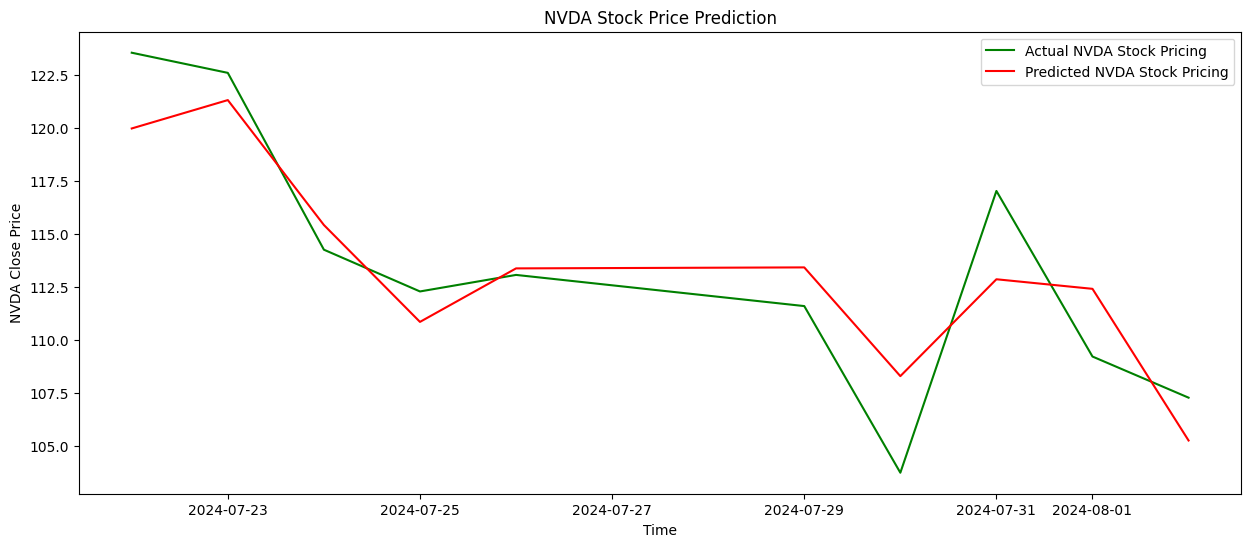

In [29]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(raw_df[len(raw_df)-len(y_test):].index, y_test, color="green", label="Actual NVDA Stock Pricing")
axes.plot(raw_df[len(raw_df)-len(y_test):].index, y_test_pred, color="red", label="Predicted NVDA Stock Pricing")

plt.title("NVDA Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("NVDA Close Price")
plt.legend()
plt.show()


Let's have the model predict the upcoming Close values for NVIDIA from the last time it opened.

In [30]:
recent_nvda_df = nvda.history(period="1d") # ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max']

In [31]:
recent_nvda_df.isnull().values.any()
recent_nvda_df.drop(columns=["Dividends", "Stock Splits"], inplace=True)

recent_features = recent_nvda_df.drop("Close", axis=1)
recent_label_df = recent_nvda_df.pop("Close")
recent_label_df.rename("Close", inplace=True)

Date
2024-08-02 00:00:00-04:00    107.269997
Name: Close, dtype: float64

In [32]:
norm_df = feature_normalizer.transform(recent_features)
newdf = pd.DataFrame(norm_df, index=recent_features.index, columns=recent_features.columns)

# for sake of demonstration (because close sometimes is in dataset), we will normalize this
# norm_df = label_normalizer.transform(recent_label_df.to_frame())
# recent_label_df = pd.DataFrame(norm_df, index=recent_label_df.index, columns=["Close"])

In [33]:
newdf.head() # only one row to represent one day

,Open,High,Low,Volume
Date,,,,
2024-08-02 00:00:00-04:00,0.307166,0.377699,0.315886,0.463329


In [34]:
recent_label_df.head() # this is what the close value should be

Date
2024-08-02 00:00:00-04:00    107.269997
Name: Close, dtype: float64

In [35]:
recent_features, recent_label = torch.tensor(newdf.values, dtype=torch.float, device=device), torch.tensor(recent_label_df.values, dtype=torch.float, device=device)
# recent_features = recent_features.to(device)
# recent_label = recent_label.to(device)

In [36]:
print(f"recent_features: {recent_features.device}, recent_label: {recent_label.device}")

recent_features: cuda:0, recent_label: cuda:0


In [37]:
model.eval()
with torch.inference_mode():
    prediction = model(recent_features)

In [38]:
prediction_df = pd.DataFrame(data=prediction.cpu(), columns=["Close"])
norm_prediction = label_normalizer.inverse_transform(prediction_df) # format: [[NUMBER]], access via norm_prediction[0][0]
print(norm_prediction)

[[105.249886]]


In [39]:
recent_label_df

Date
2024-08-02 00:00:00-04:00    107.269997
Name: Close, dtype: float64

In [40]:
real_close_value = recent_label_df.iloc[0] # first value of Series
predicted_close_value = norm_prediction[0][0]

print(f"Predicted Close Value: ${predicted_close_value:.2f}, Actual Close Value: ${real_close_value:.2f}")

Predicted Close Value: $105.25, Actual Close Value: $107.27
